In [1]:
import dill
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import matplotlib.pyplot as plt
import tomllib
from tqdm.auto import tqdm

%matplotlib inline

In [2]:
from burst import load_basis, simulate_population
from utils import segment_times

In [3]:
config = tomllib.load(open("sinegaussian_selection.toml", "rb"))

bounds = config["bounds"]

duration = config["duration"]
sample_rate = config["sample_rate"]
times = segment_times(duration, sample_rate)

In [4]:
rng_key = jax.random.PRNGKey(20)

In [5]:
basis, weights = load_basis("sinegaussian_svd_250502.pkl", truncation=config["truncation"])

In [6]:
true_mean = 5
fpeaks = np.linspace(*config["frequency_evaluation_bounds"], config["selection"]["n_points"] // 5)
offset = config["configurations"]["offset"]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

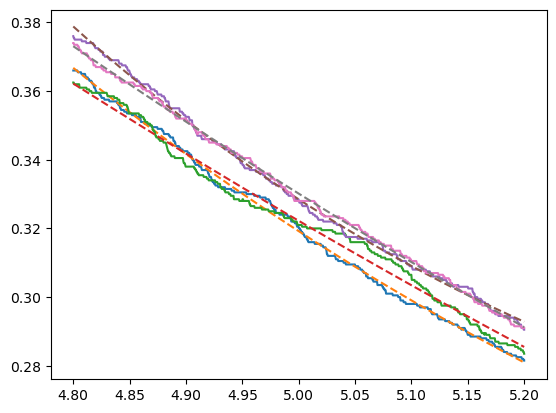

In [7]:

simulate_kwargs = dict(
    basis=basis,
    bounds=bounds,
    times=times,
    duration=duration,
    sample_rate=sample_rate,
    time_align=True,
)

polyfits = dict()

for (true_sigma, snr_threshold) in zip(
    config["configurations"]["sigma"], config["configurations"]["threshold"]
):
    if snr_threshold == 0:
        continue
    rng_key, subkey = jax.random.split(rng_key)
    pdets = np.array([
        np.mean(simulate_population(
            subkey,
            mean=true_mean,
            sigma=true_sigma,
            offset=offset,
            threshold=snr_threshold,
            n_events=config["selection"]["n_events"],
            **simulate_kwargs,
        )[2])
        for true_mean in tqdm(fpeaks)
    ])
    pfit = np.polyfit(fpeaks, np.log(pdets), 2)
    polyfits[true_sigma] = pfit
    plt.plot(fpeaks, pdets)
    plt.plot(fpeaks, np.exp(np.polyval(pfit, fpeaks)), linestyle="--")
plt.show()
plt.close()

with open("polyfits.pkl", "wb") as f:
    dill.dump(polyfits, f)

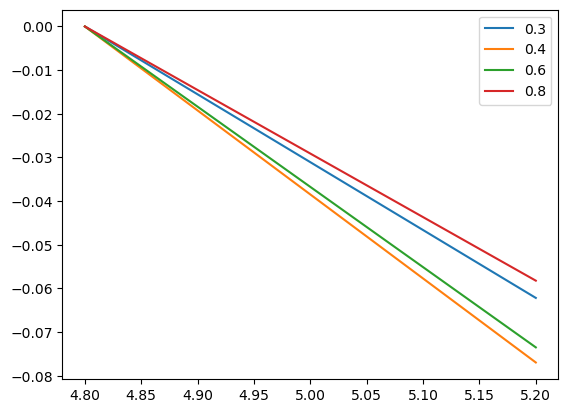

In [8]:
for key, value in polyfits.items():
    plt.plot(fpeaks, np.polyval(value, fpeaks) - np.polyval(value, fpeaks)[0], label=key)
plt.legend(loc="best")
plt.show()
plt.close()

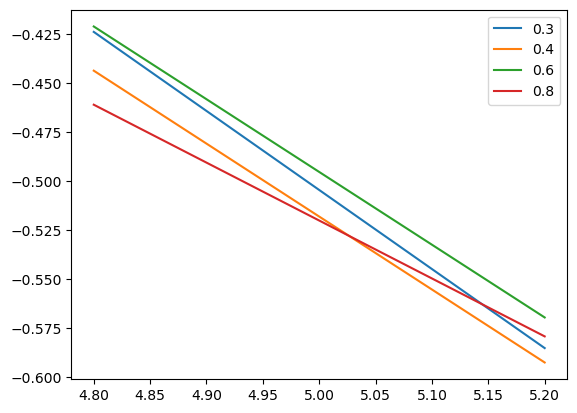

In [12]:
for key, value in polyfits.items():
    plt.plot(fpeaks, np.polyval(value, fpeaks), label=key)
plt.legend(loc="best")
plt.show()
plt.close()